In [51]:
import torch
import numpy as np
PATH = '/home/michael/Master-Thesis/CKIM_Competition/exp/Feature_Analysis_Graph-DC_FedVAE_2_out_global_private_NEW_sim_loss_lr_0_1_A0_F0_001_G0_001_H10_I0_1sim_loss_mse/FedDomSep_GraphDC_gin_on_fs_contest_data_lr0.1_lstep1_/sub_exp_20230312165013/features/client_12'

In [52]:
interm_trains = []
global_trains = []
local_trains = []
labels = []


In [53]:
from glob import glob
import os

all_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, '*.pt'))]
all_files.sort()

In [54]:
os.walk(PATH)

<generator object _walk at 0x7fbd3c871580>

In [55]:
for file in all_files:
    file_name = os.path.basename(file)
    file_name_without_ending = file_name[:-3]
    if file_name_without_ending.startswith('global_val') and not file_name_without_ending.endswith('labels'):
        global_trains.append(torch.load(file).cpu().detach().numpy())
    if file_name_without_ending.startswith('interm_val') and not file_name_without_ending.endswith('labels'):
        interm_trains.append(torch.load(file).cpu().detach().numpy())
    if file_name_without_ending.startswith('local_val') and not file_name_without_ending.endswith('labels'):
        local_trains.append(torch.load(file).cpu().detach().numpy())
    if file_name_without_ending.startswith('val') and file_name_without_ending.endswith('labels'):
        labels.append(torch.load(file).cpu().detach().numpy())

In [56]:
interm_train = np.concatenate(interm_trains)
global_train = np.concatenate(global_trains)
local_train = np.concatenate(local_trains)
labels = np.concatenate(labels)

In [57]:
diff_train = interm_train - global_train

In [58]:
diff_train

array([[ 0.        ,  0.        ,  0.        , ..., -0.10868526,
        -0.10613276,  0.00459787],
       [ 0.        ,  0.        ,  0.01727256, ..., -0.12138049,
        -0.14022824,  0.02427103],
       [ 0.        ,  0.        ,  0.        , ..., -0.12639327,
        -0.11259504,  0.02978016],
       ...,
       [ 0.        ,  0.00230165, -0.0191062 , ...,  0.0548377 ,
        -0.00321126,  0.06524143],
       [ 0.        ,  0.        , -0.0432644 , ...,  0.3306189 ,
         0.        ,  0.        ],
       [ 0.20099624,  0.02233587,  0.04754809, ..., -0.34146556,
        -0.31179893, -0.10432321]], dtype=float32)

In [59]:
diff_train.sum()

-223.14694

In [33]:
#interm_train

In [34]:
#local_train

In [35]:
np.sum(local_train != 0)


2953

In [36]:
np.sum(interm_train != 0)

2839

In [37]:
interm_train.sum()

257.1223

In [38]:
interm_train.sum() / np.sum(interm_train != 0)

0.09056791632727193

In [39]:
x = interm_train * local_train
x.sum()

3.1541474

In [40]:
f = x != 0
f.sum()

277

In [41]:
cos_sim = torch.nn.CosineSimilarity()
x = cos_sim(torch.Tensor(interm_train), torch.Tensor(local_train))
x.mean()

tensor(0.0195)

In [702]:
from sklearn.metrics.pairwise import cosine_similarity

In [703]:
class DiffLoss(torch.nn.Module):

    def __init__(self):
        super(DiffLoss, self).__init__()

    def forward(self, input1, input2):
        batch_size = input1.size(0)
        input1 = input1.view(batch_size, -1)
        input2 = input2.view(batch_size, -1)

        input1_l2_norm = torch.norm(input1, p=2, dim=1, keepdim=True).detach()
        input1_l2 = input1.div(input1_l2_norm.expand_as(input1) + 1e-6)

        input2_l2_norm = torch.norm(input2, p=2, dim=1, keepdim=True).detach()
        input2_l2 = input2.div(input2_l2_norm.expand_as(input2) + 1e-6)

        diff_loss = torch.mean((input1_l2.t().mm(input2_l2)).pow(2))

        return diff_loss

In [704]:
diffLoss = DiffLoss()
diffLoss(torch.Tensor(interm_train[:64,:]), torch.Tensor(local_train[:64,:]))

tensor(0.3265)

In [705]:
x

tensor([0.0000, 0.0000, 0.0845, 0.0316, 0.0000, 0.0000, 0.1299, 0.0023, 0.0663,
        0.0048, 0.0000, 0.0492, 0.0017, 0.0006, 0.0072, 0.0000, 0.0048, 0.0000,
        0.0000, 0.0125, 0.0000, 0.0000, 0.0287, 0.0000, 0.0000, 0.0916, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0108, 0.0030, 0.0000, 0.0000, 0.0000, 0.0974,
        0.0000, 0.0000, 0.1554, 0.0565, 0.0000, 0.0277, 0.0021, 0.0000, 0.0244,
        0.0000, 0.0526, 0.1023, 0.0826, 0.0318, 0.0000, 0.0051, 0.0000, 0.0212,
        0.0000, 0.0000, 0.0136, 0.0388, 0.0000, 0.0171, 0.0605, 0.2713, 0.0083,
        0.0000, 0.0071, 0.0000, 0.0000])

In [706]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#global_train = scaler.fit_transform(global_train)
#interm_train = scaler.fit_transform(interm_train)
#local_train = scaler.fit_transform(local_train)

In [707]:
import numpy as np
#concat_X=global_train
concat_X = np.concatenate([global_train, interm_train, local_train])

In [708]:
from sklearn.manifold import TSNE

In [709]:
labels_global = labels.copy()
labels_interm = labels.copy() + 2
labels_local = labels.copy() + 4
labels = np.concatenate([labels_global, labels_interm, labels_local])

In [710]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=25).fit_transform(concat_X, labels)

In [711]:
X_embedded

array([[-7.95052767e+00,  7.22424650e+00],
       [-6.61820984e+00,  5.19681883e+00],
       [-1.31829917e+00,  1.83442080e+00],
       [-8.28844547e-01,  9.16503716e+00],
       [-5.59878540e+00,  9.07061195e+00],
       [ 1.53264463e+00,  1.96608758e+00],
       [ 1.40385447e+01,  4.73907089e+00],
       [ 1.40082331e+01,  4.98502874e+00],
       [ 8.17937756e+00,  4.57284600e-01],
       [ 8.19764709e+00,  4.66446400e-01],
       [ 4.46851015e+00,  1.10166967e+00],
       [ 1.40883198e+01,  4.15138388e+00],
       [ 1.65600386e-02,  1.81374416e-01],
       [-4.22583914e+00,  8.66160870e+00],
       [ 4.53627205e+00,  1.11645937e+00],
       [-9.67146969e+00,  8.72087383e+00],
       [ 8.19764709e+00,  4.66446400e-01],
       [-2.10442615e+00,  2.70498872e+00],
       [ 7.10971713e-01,  1.30229068e+00],
       [-3.02104712e+00,  6.80179310e+00],
       [-4.03634167e+00,  8.63512039e+00],
       [-1.56298494e+00,  2.80494857e+00],
       [-7.37026167e+00,  5.88713598e+00],
       [-7.

In [712]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30, 18))
plt.rcParams["figure.figsize"] = (30,18)

<Figure size 3000x1800 with 0 Axes>

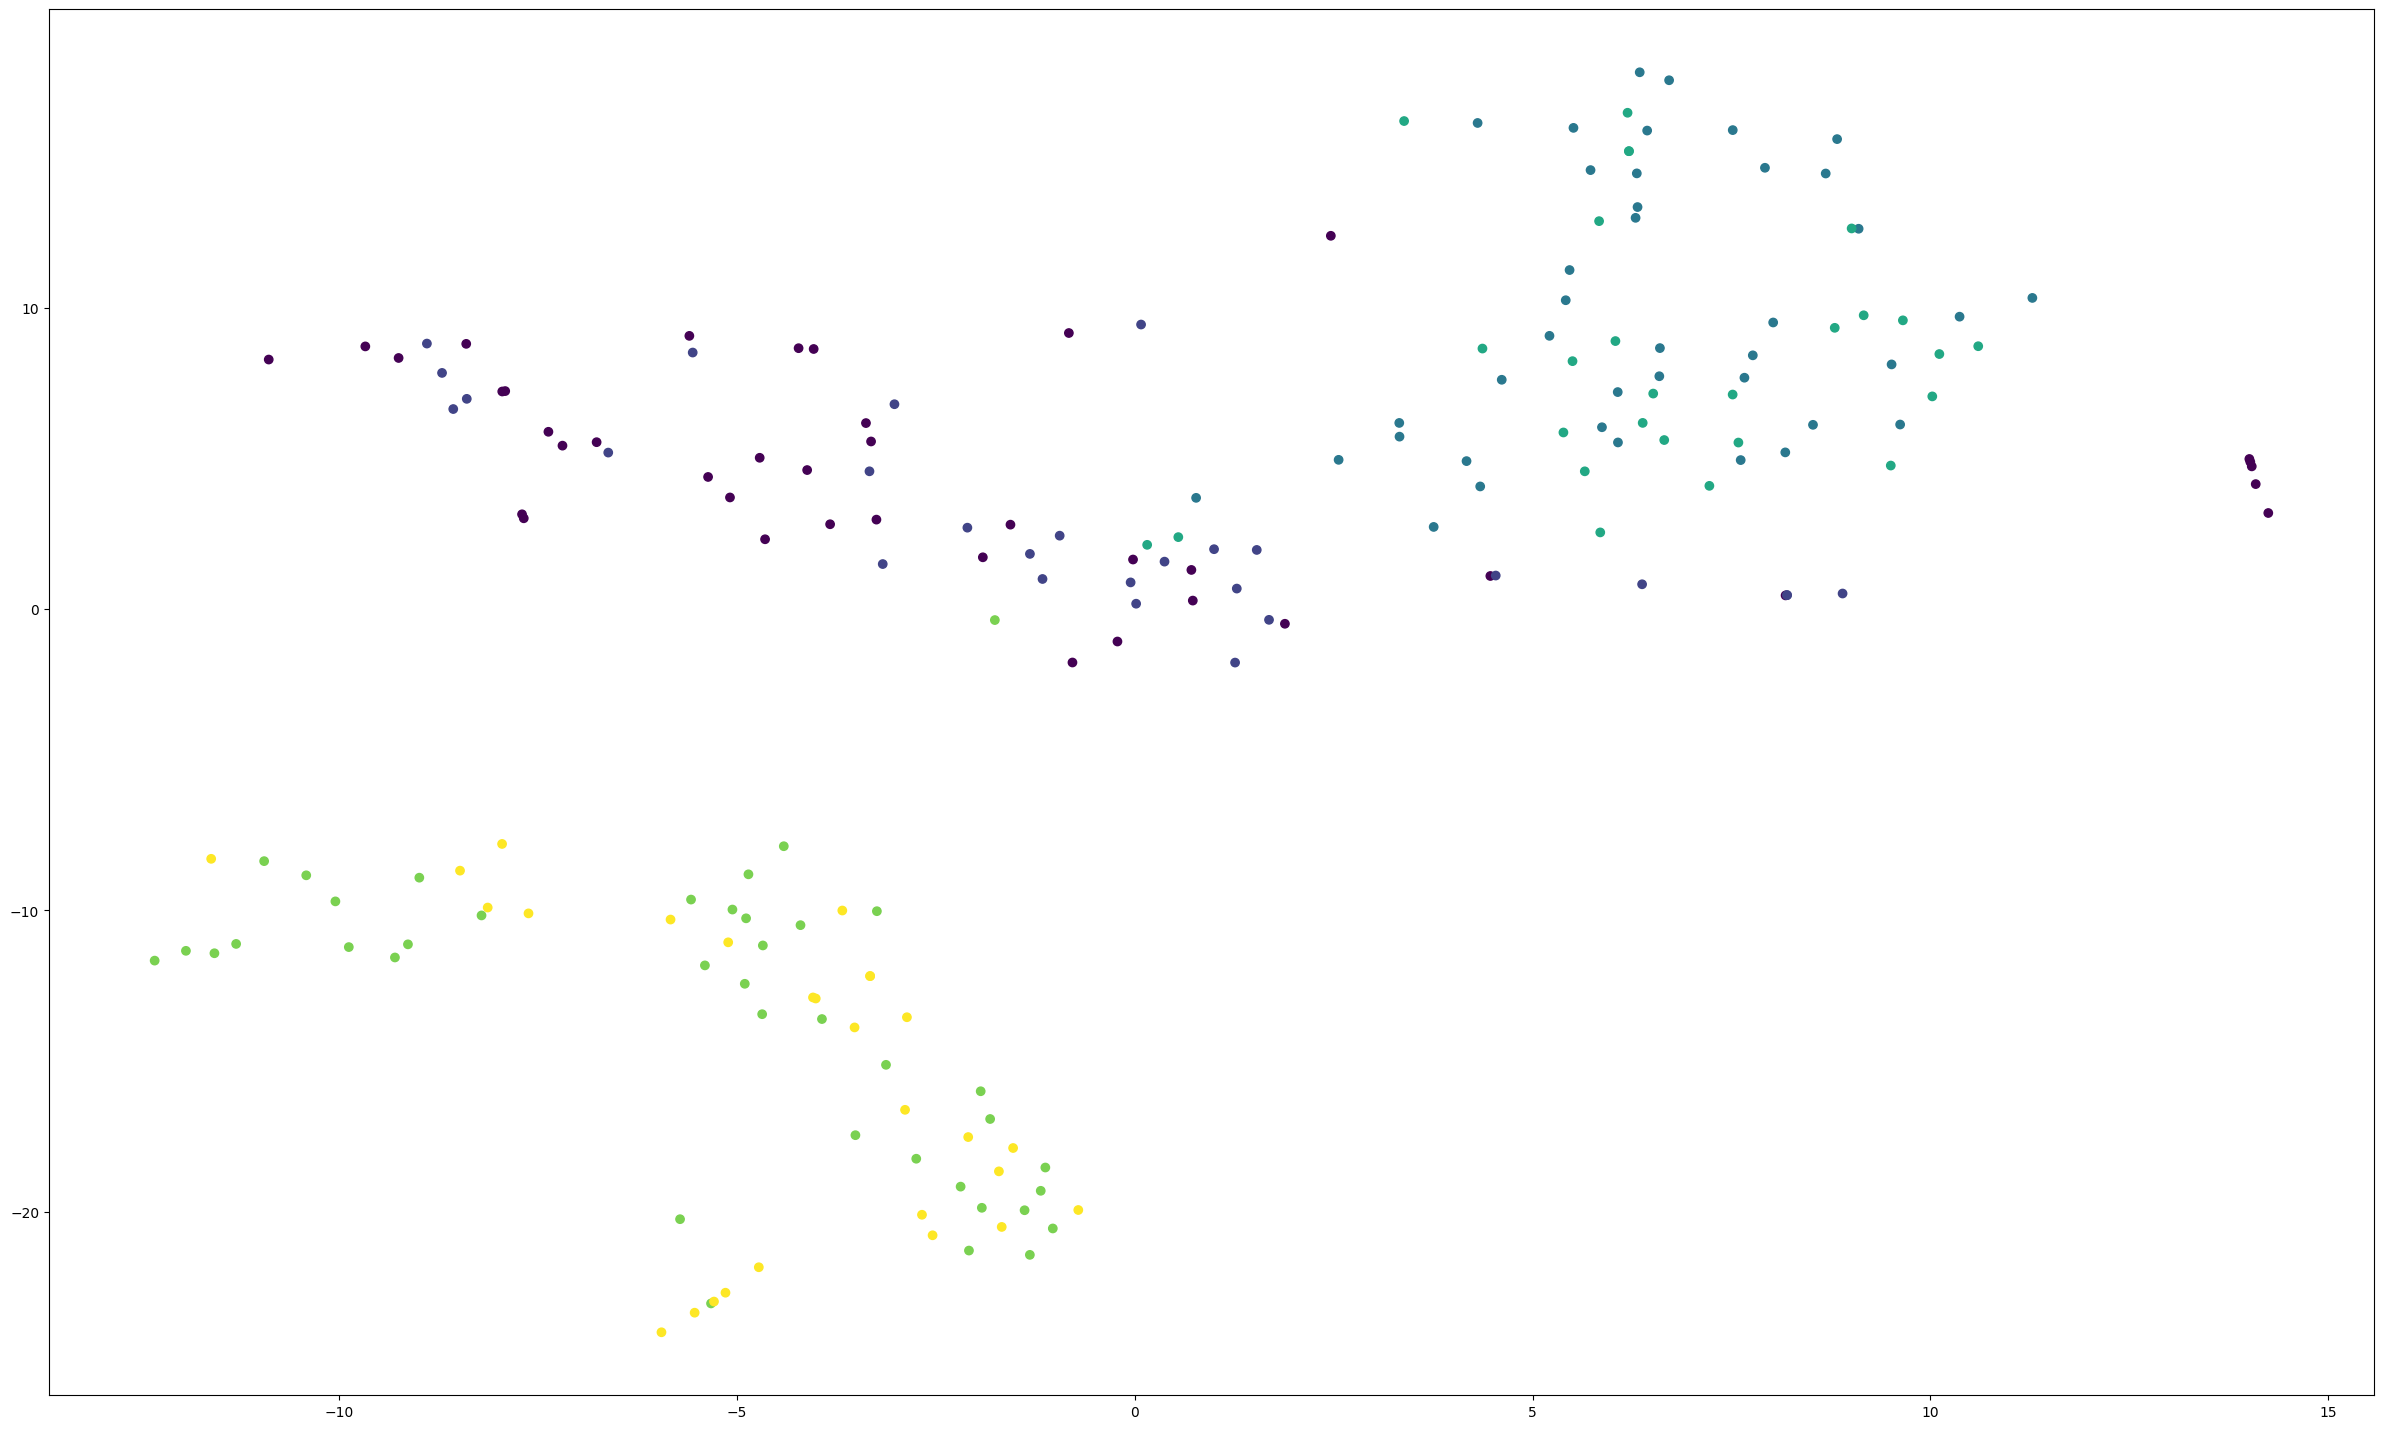

In [713]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels)
plt.show()

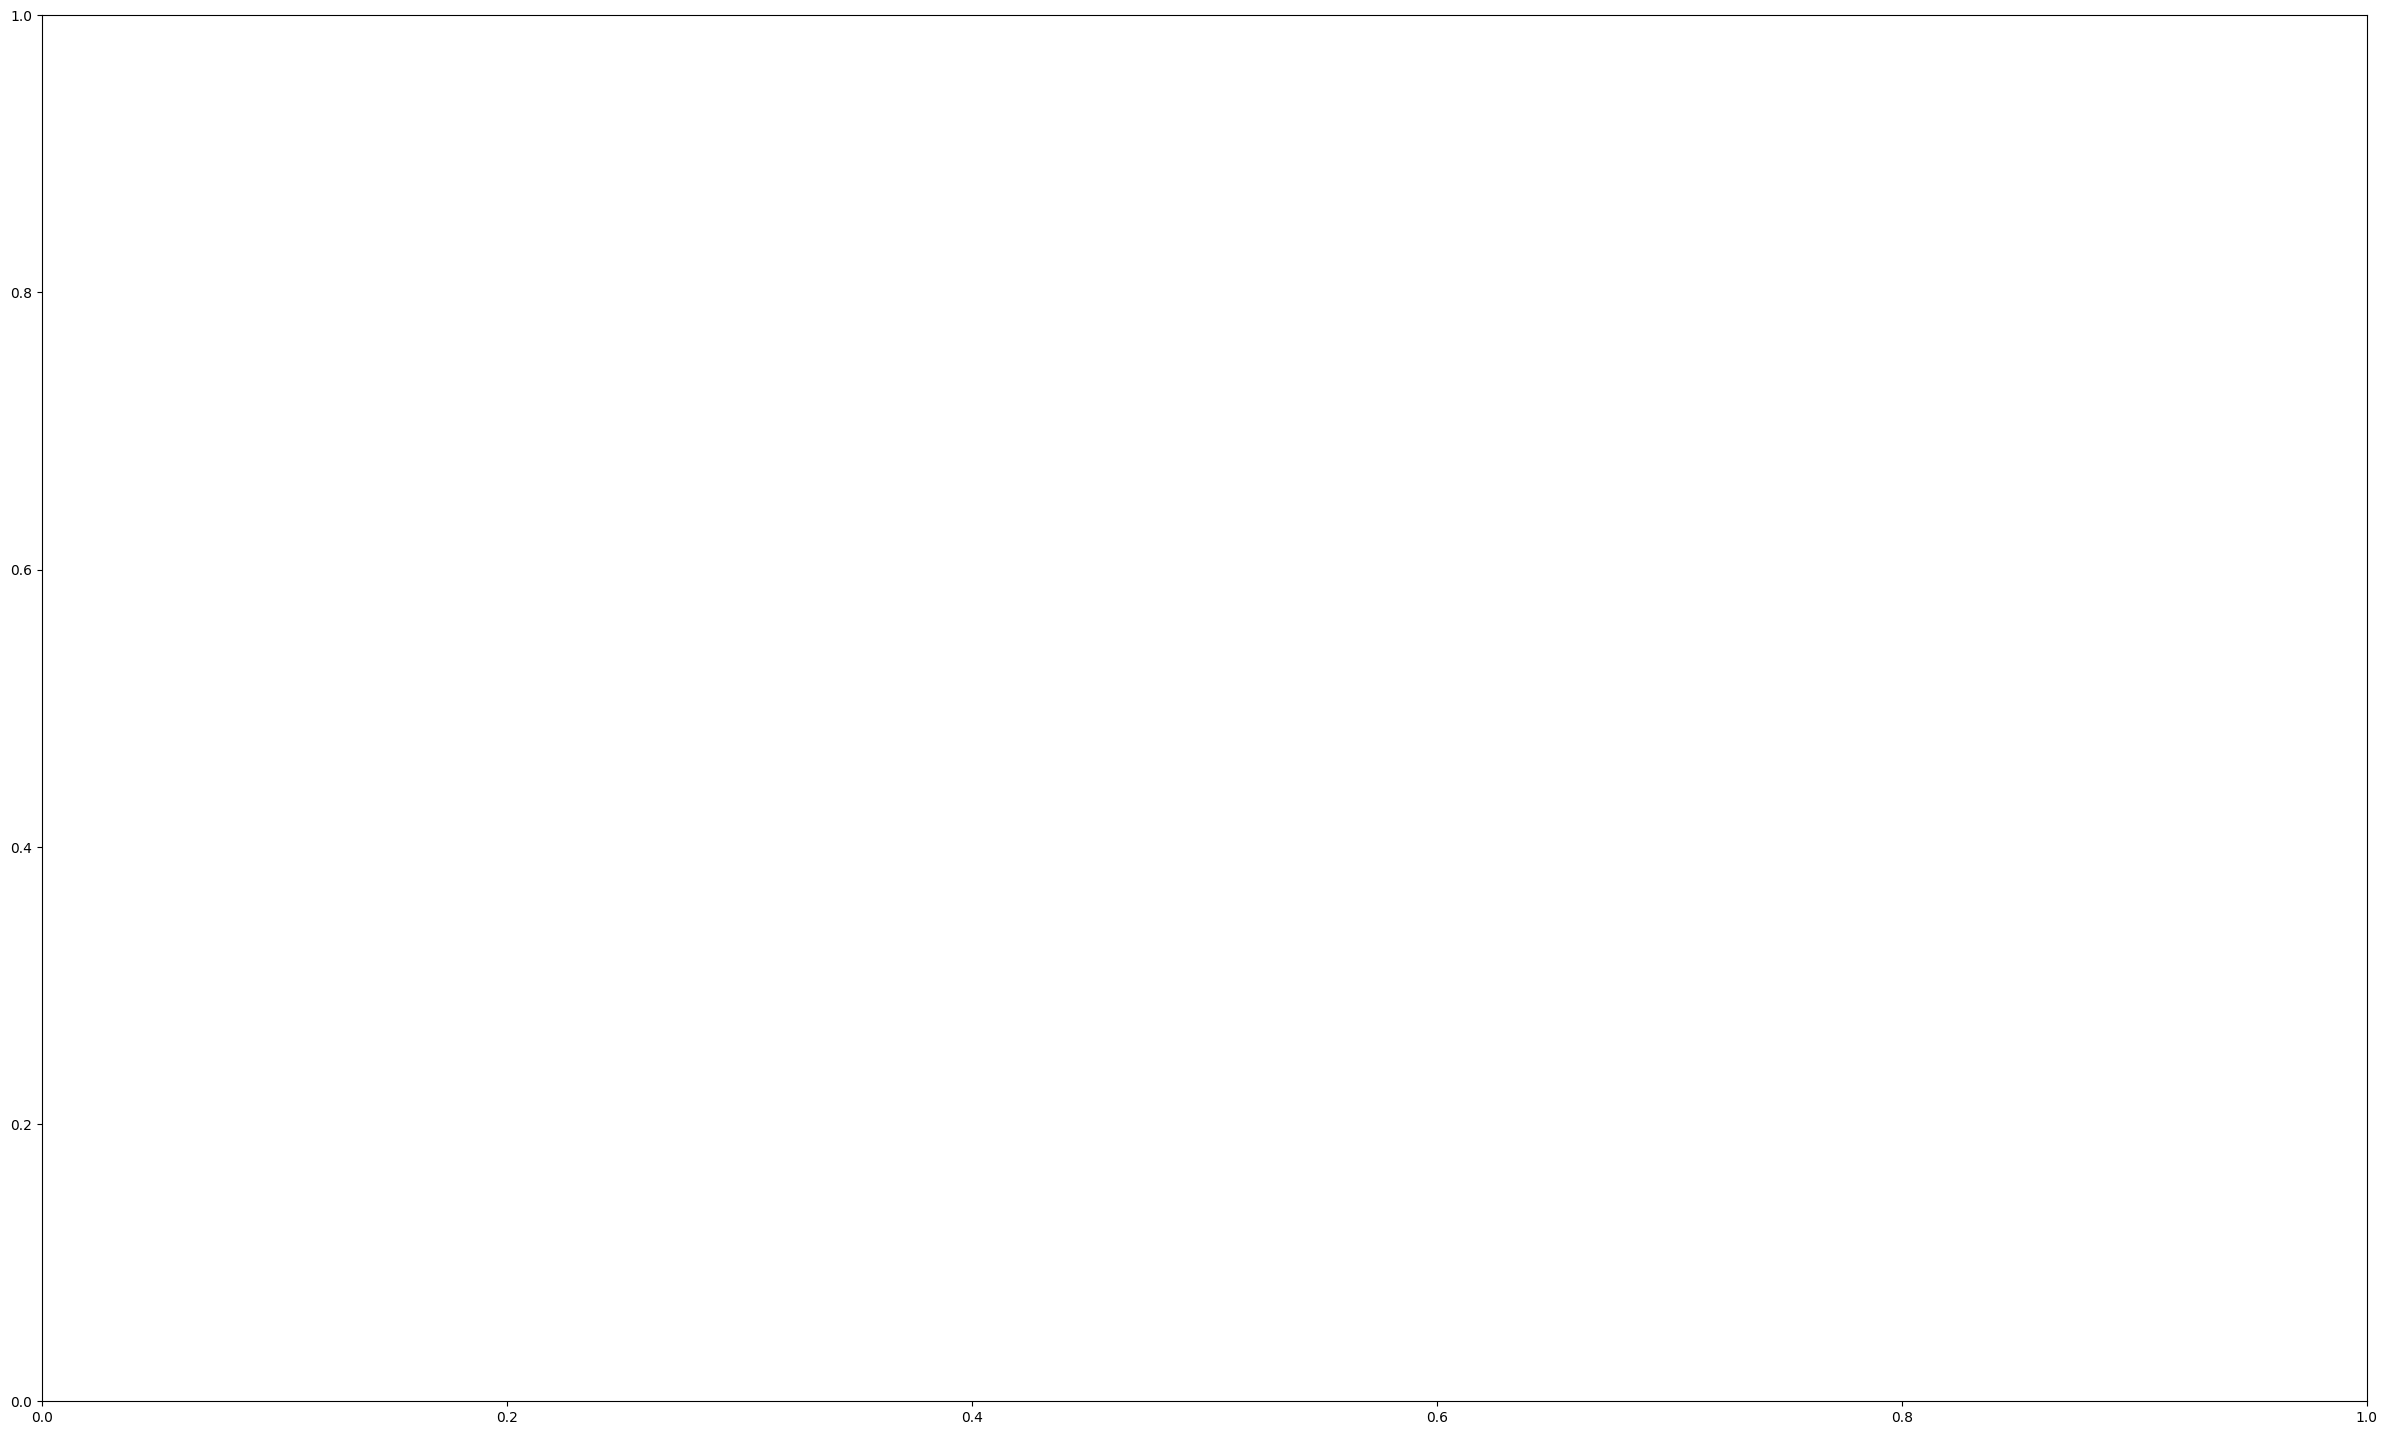

In [714]:

fig, ax = plt.subplots()

In [715]:
color_map = {0:'red', 1:'yellow', 2:'orange', 3:'green', 4:'cyan', 5:'grey'}
colors = list(map(color_map.get, labels))

In [716]:
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=colors)

In [717]:
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

/home/michael/Master-Thesis/CKIM_Competition/venv/lib/python3.9/site-packages/matplotlib/collections.py:1084: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


In [718]:
ax.add_artist(legend1)

In [719]:
plt.show()

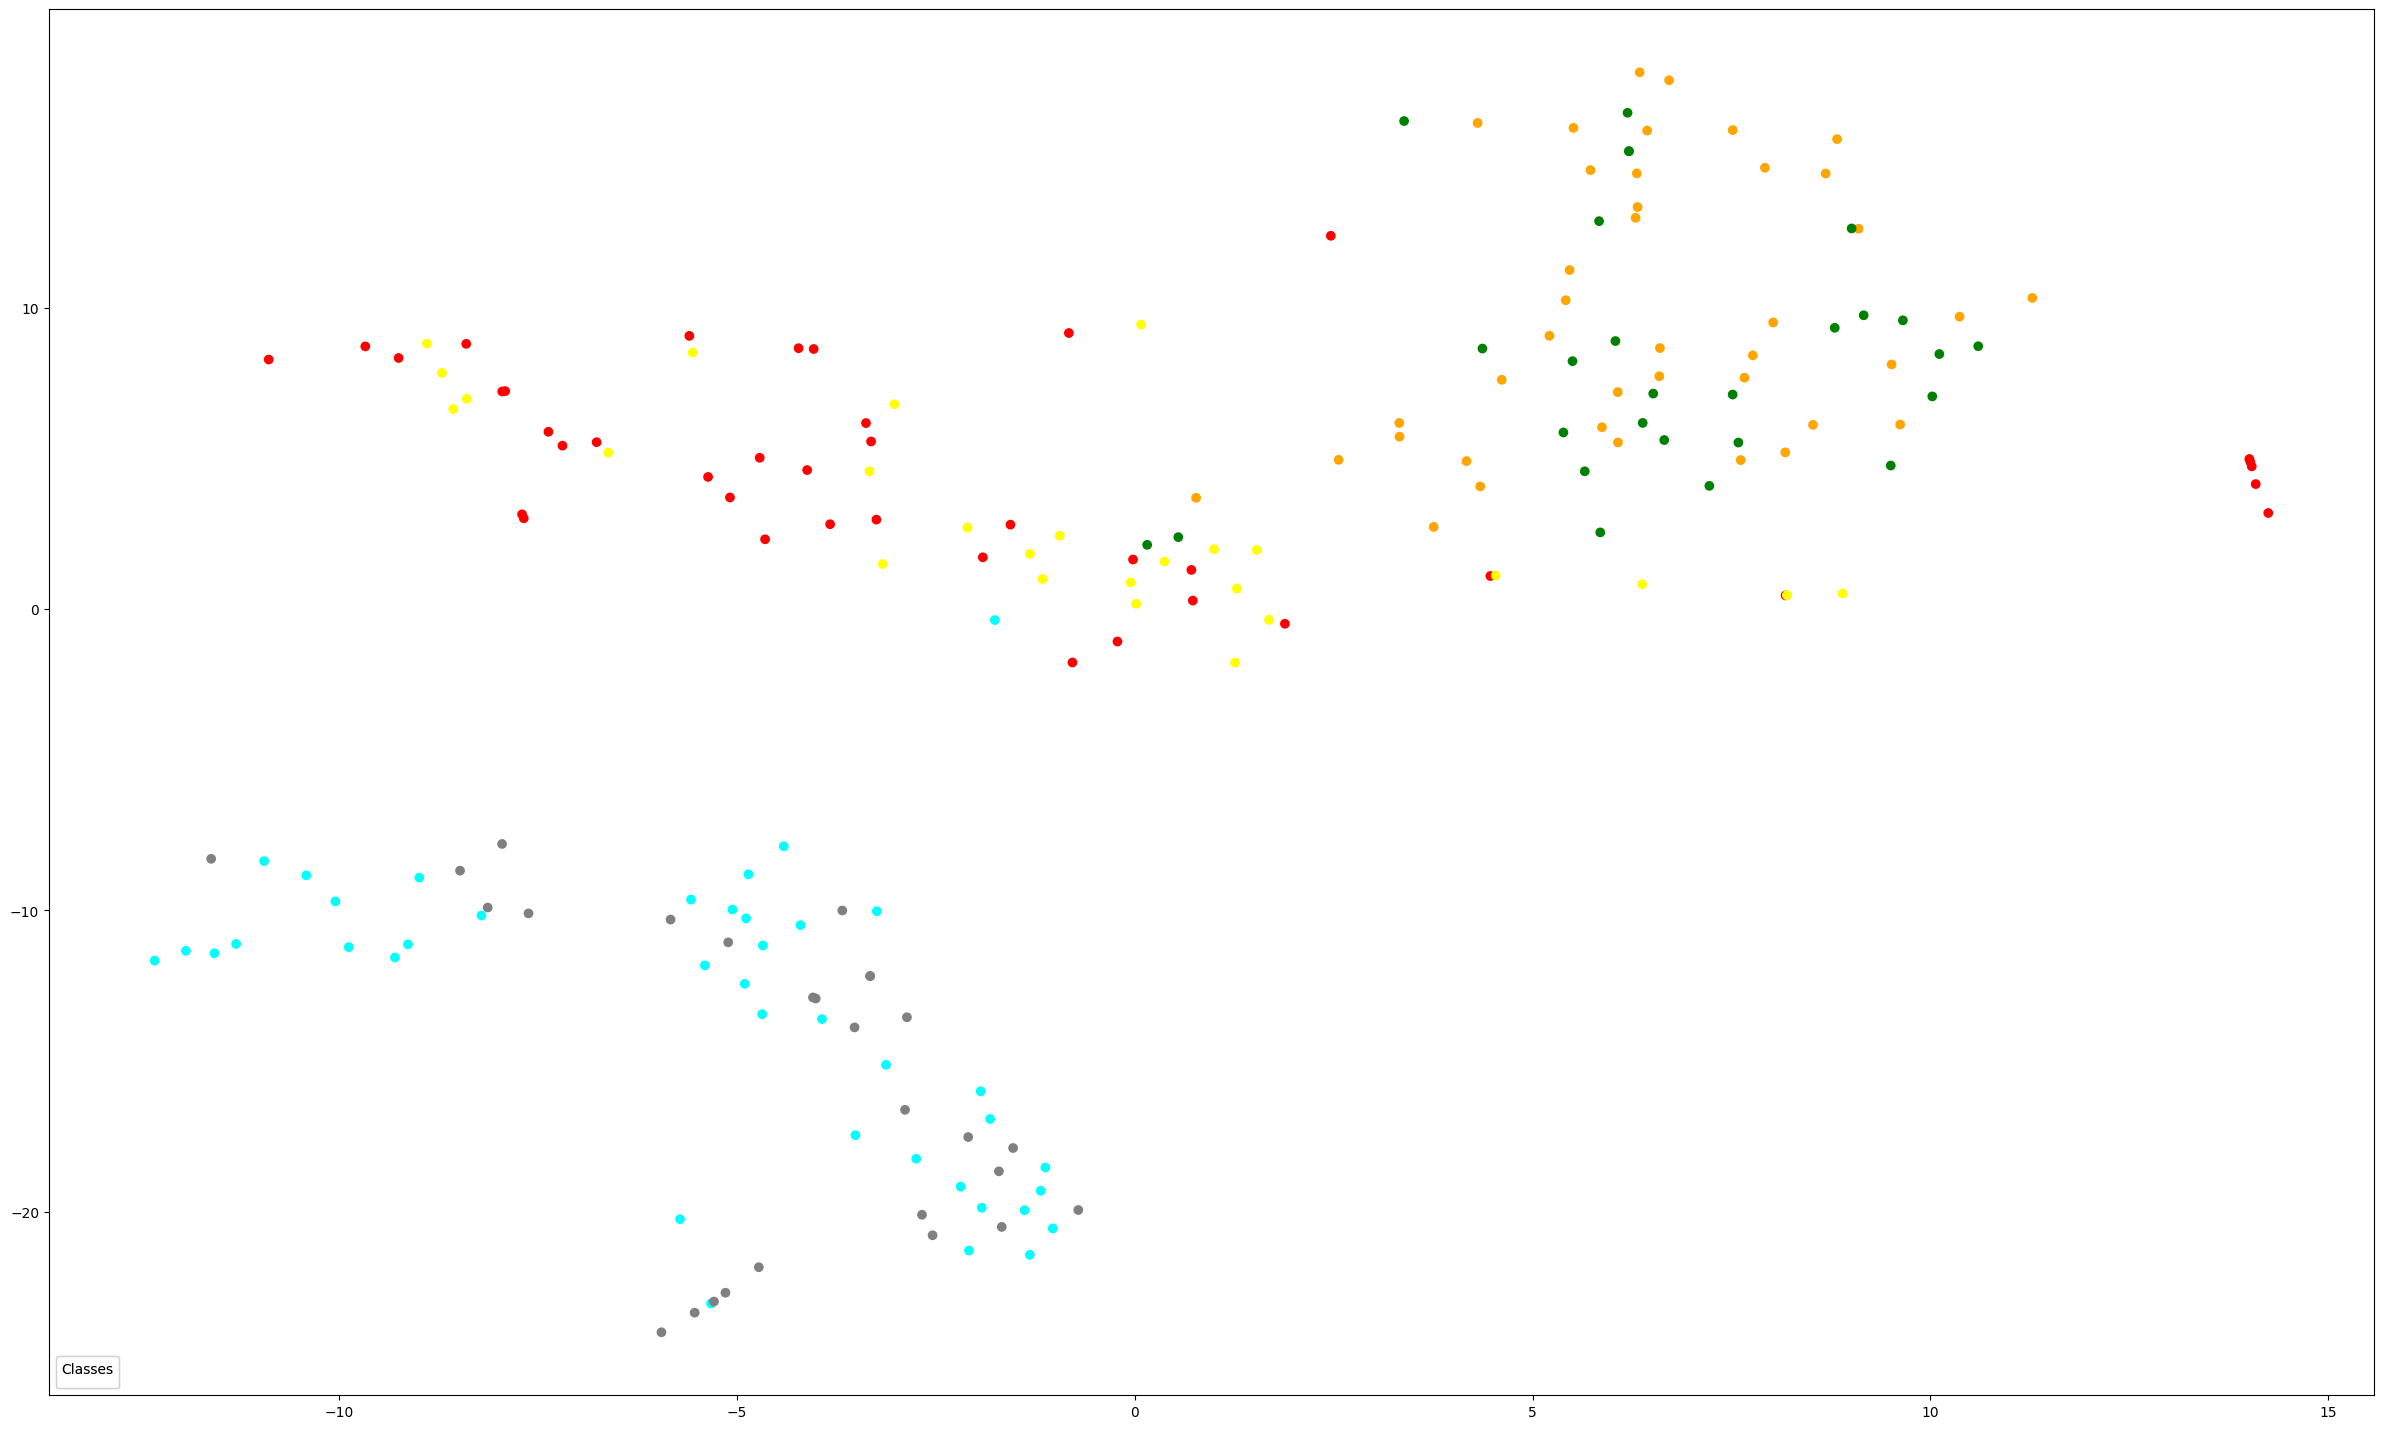

In [720]:
fig

In [721]:
scatter.legend_elements()

([], [])

In [722]:
X_embedded.shape[0]

201

In [723]:
X_embedded.shape[0]//2

100

In [724]:
X_embedded_combined = X_embedded[:X_embedded.shape[0]//2, :]

In [725]:
X_embedded_combined

array([[-7.95052767e+00,  7.22424650e+00],
       [-6.61820984e+00,  5.19681883e+00],
       [-1.31829917e+00,  1.83442080e+00],
       [-8.28844547e-01,  9.16503716e+00],
       [-5.59878540e+00,  9.07061195e+00],
       [ 1.53264463e+00,  1.96608758e+00],
       [ 1.40385447e+01,  4.73907089e+00],
       [ 1.40082331e+01,  4.98502874e+00],
       [ 8.17937756e+00,  4.57284600e-01],
       [ 8.19764709e+00,  4.66446400e-01],
       [ 4.46851015e+00,  1.10166967e+00],
       [ 1.40883198e+01,  4.15138388e+00],
       [ 1.65600386e-02,  1.81374416e-01],
       [-4.22583914e+00,  8.66160870e+00],
       [ 4.53627205e+00,  1.11645937e+00],
       [-9.67146969e+00,  8.72087383e+00],
       [ 8.19764709e+00,  4.66446400e-01],
       [-2.10442615e+00,  2.70498872e+00],
       [ 7.10971713e-01,  1.30229068e+00],
       [-3.02104712e+00,  6.80179310e+00],
       [-4.03634167e+00,  8.63512039e+00],
       [-1.56298494e+00,  2.80494857e+00],
       [-7.37026167e+00,  5.88713598e+00],
       [-7.

In [726]:
X_embedded_local = X_embedded[X_embedded.shape[0]//2:, :]

In [727]:
X_embedded_local

array([[  3.3238332 ,   6.180916  ],
       [  5.513246  ,  15.973459  ],
       [  9.160988  ,   9.753364  ],
       [  6.383352  ,   6.182154  ],
       [  7.6620326 ,   7.6819696 ],
       [ 11.280896  ,  10.329872  ],
       [  4.308505  ,  16.136408  ],
       [  6.6540823 ,   5.613214  ],
       [  9.653655  ,   9.585917  ],
       [  5.416158  ,  10.253253  ],
       [  5.655528  ,   4.575094  ],
       [  7.5151505 ,  15.899537  ],
       [  6.318526  ,  13.345319  ],
       [  6.715379  ,  17.554043  ],
       [  9.501406  ,   4.766759  ],
       [  8.02324   ,   9.514858  ],
       [  9.009426  ,  12.635581  ],
       [  3.3269591 ,   5.726058  ],
       [  7.7672915 ,   8.424495  ],
       [  7.51399   ,   7.123437  ],
       [  4.369316  ,   8.649708  ],
       [  6.592433  ,   7.7307687 ],
       [  6.2940106 ,  12.987884  ],
       [  6.439526  ,  15.883667  ],
       [  7.9200068 ,  14.648946  ],
       [  0.7703786 ,   3.6949124 ],
       [  6.1931977 ,  16.47495   ],
 

In [728]:
x_diff = X_embedded_local - X_embedded_combined

ValueError: operands could not be broadcast together with shapes (101,2) (100,2) 

In [ ]:
x_diff

In [ ]:
labels